# Описание решения
Из исходников компилируется 13 программ (по одной на каждую сортировку). Каждая программа принимает в качестве аргументов размер массива и сам массив, который сортирует. С помощью библиотеки `chrono` измеряется время выполнения функции сортировки. Все измерения записываются в датафреймы. Если массив не сортируется или засекается время выполнения равняется 0, то процесс прерывается с ошибкой, а массив, на котором все сломалось, выводится в текстовый файл debug.txt

## Импорты и функции

In [ ]:
import random
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

type_names = ["random 0-5", "random 0-4000", "almost sorted", "reversed"]
sorting_names = ["selection", "bubble", "bubble1", "bubble2", "insertion", "binsertion", 
                 "counting", "radix", "merge", "quick", "heap", "shellciura", "shell"]
inplace_sortings = ["selection", "bubble", "bubble1", "bubble2", "insertion", "binsertion", "radix", "merge", "quick", "shellciura", "shell"]
not_inplace_sortings = ["counting", "heap"]

# Компиляция исходников
def compile():
  for name in inplace_sortings:
    command = "g++ main.cpp measure_inplace_sort.cpp " + name + ".cpp -o " + name
    subprocess.check_output(command, shell=True)
  for name in not_inplace_sortings:
    command = "g++ main.cpp measure_sort.cpp " + name + ".cpp -o " + name
    subprocess.check_output(command, shell=True)

# Замеры
def iterate_sortings(array, size):
  measurements = []
  for name in sorting_names:
    command = "./" + name + " " + str(size) + " \"" + " ".join(str(a) for a in array) + "\""
    output = subprocess.check_output(command, shell=True)
    measurement = float(output.decode("utf-8"))
    measurements.append(measurement)
    if measurement == 0:
      raise ValueError('Array is not sorted or measured time equals 0.')
  return measurements

def iterate_sizes(array, step, start, end):
  measurements = []
  while start <= end:
    measurements.append(start)
    res = iterate_sortings(array, start)
    measurements.extend(res)
    start += step
  return measurements
  
def iterate_intervals(array):
  measurements = []
  res = iterate_sizes(array, 50, 50, 300)
  measurements.extend(res)
  res = iterate_sizes(array, 100, 100, 4100)
  measurements.extend(res)
  return measurements

def generate_random_array(size, start, end):
  array = []
  for i in range(size):
    array.append(random.randint(start, end))
  return array

def generate_almost_sorted_array(size, param):
  array_sorted = list(range(0, size))
  for i in range(param):
    a = random.randint(0, size)
    b = random.randint(0, size)
    array_sorted[a], array_sorted[b] = array_sorted[b], array_sorted[a]
  return array_sorted

# Конвертация списка в data frame
def convert_to_df(lst):
  arr = np.array(lst)
  arr = arr.reshape(len(lst) // (len(sorting_names) + 1), len(sorting_names) + 1)
  column_names = ["size"]
  column_names.extend(sorting_names)
  df = pd.DataFrame(arr, columns=column_names)
  df = df.astype({'size':'int'})
  return df

# Графики
def plot_sortings_comparison(df, text, ylb):
  f = plt.figure()
  f.set_figwidth(15)
  f.set_figheight(5)

  plt.subplot(1, 2, 1)
  x = df["size"].values.tolist()[:6]
  for sorting in sorting_names:
    y = df[sorting].values.tolist()[:6]
    plt.plot(x, y, label = sorting)
  plt.xlabel('Array size')
  plt.ylabel(ylb)
  plt.legend()
  plt.title(text)

  plt.subplot(1, 2, 2)
  x = df["size"].values.tolist()[6:]
  for sorting in sorting_names:
    y = df[sorting].values.tolist()[6:]
    plt.plot(x, y, label = sorting)
  plt.xlabel('Array size')
  plt.ylabel(ylb)
  plt.legend()
  plt.title(text)


def plot_sortings(dfs, name, ylb):
  f = plt.figure()
  f.set_figwidth(15)
  f.set_figheight(5)

  plt.subplot(1, 2, 1)
  ind = 0
  for df in dfs:
    x = df["size"].values.tolist()[:6]
    y = df[name].values.tolist()[:6]
    plt.plot(x, y, label = type_names[ind])
    ind += 1
  plt.xlabel('Array size')
  plt.ylabel(ylb)
  plt.legend()
  plt.title(name)

  plt.subplot(1, 2, 2)
  ind = 0
  for df in dfs:
    x = df["size"].values.tolist()[6:]
    y = df[name].values.tolist()[6:]
    plt.plot(x, y, label = type_names[ind])
    ind += 1
  plt.xlabel('Array size')
  plt.ylabel(ylb)
  plt.legend()
  plt.title(name)

# Измерение времени выполнения

## Подготовка исходников

Функция `main` считывает переданный через аргументы командной строки массив\
и выводит результат измерения скорости работы алгоритма в стандартный вывод.\
Функция `checker` проверяет отсортирован ли результирующий массив.\
Функция `debug_print` выводит исходный и результирующий массив в файл debug.txt.

In [ ]:
%%writefile main.cpp
#include <iostream>
#include <fstream>
#include <sstream>
#include <vector>

std::string PROGRAM_NAME;

long long measure_sort(const std::vector<int> &array);

bool checker(const std::vector<int> &array) {
    for (int i = 0; i < array.size() - 1; ++i) {
        if (array[i] > array[i + 1]) {
            return false;
        }
    }
    return true;
}

void debug_print(const std::vector<int> &array, const std::vector<int> &result) {
    std::ofstream out;
    out.open("debug.txt");
    if (out.is_open()) {
        out << PROGRAM_NAME << std::endl;
        for (int n: array) {
            out << n << ' ';
        }
        out << std::endl;
        for (int n: result) {
            out << n << ' ';
        }
        out << std::endl;
        out.close();
    }
}

int main(int argc, char **argv) {
    if (argc < 3) {
        return 0;
    }
    PROGRAM_NAME = std::string(argv[0]);
    std::string s(argv[2]);
    std::stringstream ss(s);
    int num;
    int size = std::atoi(argv[1]);
    std::vector<int> array;
    array.reserve(size * 3);
    std::vector<int> result;

    for (int i = 0; i < size; ++i) {
        ss >> num;
        array.push_back(num);
    }
    long long sum = measure_sort(array);
    std::cout << sum / 1000000.0;
    return 0;
}

Overwriting main.cpp


Засекание времени для сортировок, которые не изменяют сортируемый массив.

In [ ]:
%%writefile measure_sort.cpp
#include <vector>
#include <chrono>

const int REPEAT_NUM = 50;

void sort(std::vector<int> &to_sort, std::vector<int> &sorted);
bool checker(const std::vector<int> &array);
void debug_print(const std::vector<int> &array, const std::vector<int> &result);

long long measure_sort(const std::vector<int> &array) {
    long long sum = 0;
    std::vector<int> sorted;
    sorted.reserve(array.size() * 3);
    for (int i = 0; i < REPEAT_NUM; ++i) {
        std::vector<int> to_sort(array);
        to_sort.reserve(array.size() * 3);
        auto start = std::chrono::high_resolution_clock::now();
        sort(to_sort, sorted);
        auto elapsed = std::chrono::high_resolution_clock::now() - start;
        long long nanoseconds =
                std::chrono::duration_cast<std::chrono::nanoseconds>(elapsed).count();
        sum += nanoseconds;
        if (i == 0 && !checker(sorted)) {
            debug_print(array, sorted);
            return 0;
        }
        sorted.clear();
    }
    return sum / REPEAT_NUM;
}

Overwriting measure_sort.cpp


Я вынесла создание результирующего массива за пределы функции сортировки,\
поэтому такие сортировки компилируются отдельно.

Сами эти сортировки

In [ ]:
%%writefile counting.cpp
#include <vector>

void sort(std::vector<int> &to_sort, std::vector<int> &sorted) {
    const int size = 4100;
    std::vector<int> nums(size + 1, 0);
    for (int i = 0; i < to_sort.size(); ++i) {
        nums[to_sort[i]]++;
    }
    for (int i = 0; i <= size; ++i) {
        for (int j = 0; j < nums[i]; ++j) {
            sorted.push_back(i);
        }
    }
}

Overwriting counting.cpp


In [ ]:
%%writefile heap.cpp
#include <vector>
#include <functional>
#include <algorithm>

void sort(std::vector<int> &to_sort, std::vector<int> &sorted) {
    int top;
    std::make_heap(to_sort.begin(), to_sort.end(), std::greater<int>());
    while (!to_sort.empty()) {
        std::pop_heap(to_sort.begin(), to_sort.end(), std::greater<int>());
        top = to_sort.back();
        sorted.push_back(top);
        to_sort.pop_back();
    }
}

Overwriting heap.cpp


Засекание времени для сортировок inplace и они сами.

In [ ]:
%%writefile measure_inplace_sort.cpp
#include <vector>
#include <chrono>

const int REPEAT_NUM = 50;

void sort(std::vector<int> &to_sort);
bool checker(const std::vector<int> &array);
void debug_print(const std::vector<int> &array, const std::vector<int> &result);

long long measure_sort(const std::vector<int> &array) {
    long long sum = 0;
    for (int i = 0; i < REPEAT_NUM; ++i) {
        std::vector<int> to_sort(array);
        to_sort.reserve(array.size() * 3);
        auto start = std::chrono::high_resolution_clock::now();
        sort(to_sort);
        auto elapsed = std::chrono::high_resolution_clock::now() - start;
        long long nanoseconds =
                std::chrono::duration_cast<std::chrono::nanoseconds>(elapsed).count();
        sum += nanoseconds;
        if (i == 0 && !checker(to_sort)) {
            debug_print(array, to_sort);
            return 0;
        }
    }
    return sum / REPEAT_NUM;
}

Overwriting measure_inplace_sort.cpp


In [ ]:
%%writefile selection.cpp
#include <vector>

void swap(std::vector<int> &v, int f, int s) {
    int t = v[f];
    v[f] = v[s];
    v[s] = t;
}

void sort(std::vector<int> &to_sort) {
    for (int i = 0; i < to_sort.size() - 1; i++) {
        int min_index = i;
        for (int j = i + 1; j < to_sort.size(); j++) {
            if (to_sort[j] < to_sort[min_index]) {
                min_index = j;
            }
        }
        if (min_index != i) {
            swap(to_sort, i, min_index);
        }
    }
}

Overwriting selection.cpp


In [ ]:
%%writefile bubble.cpp
#include <vector>

void sort(std::vector<int> &to_sort) {
    for (int i = 0; i < to_sort.size() - 1; ++i) {
        for (int j = 0; j < to_sort.size() - 1; ++j) {
            if (to_sort[j] > to_sort[j + 1]) {
                int temp = to_sort[j];
                to_sort[j] = to_sort[j + 1];
                to_sort[j + 1] = temp;
            }
        }
    }
}

Overwriting bubble.cpp


In [ ]:
%%writefile bubble1.cpp
#include <vector>

void sort(std::vector<int> &to_sort) {
    for (int i = 0; i < to_sort.size() - 1; ++i) {
        bool b = true;
        for (int j = 0; j < to_sort.size() - 1; ++j) {
            if (to_sort[j] > to_sort[j + 1]) {
                b = false;
                int temp = to_sort[j];
                to_sort[j] = to_sort[j + 1];
                to_sort[j + 1] = temp;
            }
        }
        if (b) {
            break;
        }
    }
}

Overwriting bubble1.cpp


In [ ]:
%%writefile bubble2.cpp
#include <vector>

void sort(std::vector<int> &to_sort) {
    int k = to_sort.size() - 1;
    for (int i = 0; i < to_sort.size() - 1; ++i) {
        int t = 0;
        for (int j = 0; j < k; ++j) {
            if (to_sort[j] > to_sort[j + 1]) {
                t = j;
                int temp = to_sort[j];
                to_sort[j] = to_sort[j + 1];
                to_sort[j + 1] = temp;
            }
        }
        if (t == 0) {
            break;
        }
        k = t;
    }
}

Overwriting bubble2.cpp


In [ ]:
%%writefile insertion.cpp
#include <vector>

void swap(std::vector<int>& v, int f, int s) {
    int t = v[f];
    v[f] = v[s];
    v[s] = t;
}

void sort(std::vector<int> &to_sort) {
    for (int i = 1; i < to_sort.size(); ++i) {
        int j = i;
        while (j > 0 && to_sort[j] < to_sort[j - 1]) {
            swap(to_sort, j - 1, j);
            j--;
        }
    }
}

Overwriting insertion.cpp


In [ ]:
%%writefile binsertion.cpp
#include <vector>
#include <algorithm>

void sort(std::vector<int> &to_sort) {
    auto i = to_sort.begin() + 1;
    while (i < to_sort.end()) {
        auto p = std::upper_bound(to_sort.begin(), i, *i);
        auto j = i;
        while (j > p) {
            int t = *j;
            *j = *(j - 1);
            *(j - 1) = t;
            j--;
        }
        i++;
    }
}

Overwriting binsertion.cpp


In [ ]:
%%writefile radix.cpp
#include <vector>
#include <queue>

int const kBucketsNum = 255;
int const kRadixNum = 2;

int getbyte(int number, int bytenum) {
    long long b = kBucketsNum;
    b <<= 8 * (bytenum);
    number &= b;
    number >>= 8 * (bytenum);
    return number;
}

void sort(std::vector<int> &to_sort) {
    for (int i = 0; i < kRadixNum; ++i) {
        std::queue<int> posbuckets[kBucketsNum + 1];
        for (long long j = 0; j < to_sort.size(); ++j) {
            posbuckets[getbyte(to_sort[j], i)].push(to_sort[j]);
        }
        to_sort.clear();
        for (int j = 0; j <= kBucketsNum; ++j) {
            while (!posbuckets[j].empty()) {
                int num = posbuckets[j].front();
                posbuckets[j].pop();
                to_sort.push_back(num);
            }
        }
    }
}

Overwriting radix.cpp


In [ ]:
%%writefile merge.cpp
#include<vector>

void merge_sorted_intervals(std::vector<int> &v, int s, int m, int e) {
    std::vector<int> temp;
    temp.reserve((e - s + 5) * 2);
    int i = s;
    int j = m + 1;
    while (i <= m && j <= e) {
        if (v[i] <= v[j]) {
            temp.push_back(v[i]);
            ++i;
        }
        else {
            temp.push_back(v[j]);
            ++j;
        }
    }
    while (i <= m) {
        temp.push_back(v[i]);
        ++i;
    }
    while (j <= e) {
        temp.push_back(v[j]);
        ++j;
    }
    for (int i = s; i <= e; ++i)
        v[i] = temp[i - s];

}

void merge_sort(std::vector<int> &v, int s, int e) {
    if (s < e) {
        int m = (s + e) / 2;
        merge_sort(v, s, m);
        merge_sort(v, m + 1, e);
        merge_sorted_intervals(v, s, m, e);
    }
}

void sort(std::vector<int> &to_sort) {
    merge_sort(to_sort, 0, to_sort.size() - 1);
}

Overwriting merge.cpp


In [ ]:
%%writefile quick.cpp
#include <vector>

void swap(std::vector<int> &v, int f, int s) {
    int t = v[f];
    v[f] = v[s];
    v[s] = t;
}

int partition(std::vector<int> &v, int start, int end)
{
    int pivot = v[start];

    int count = 0;
    for (int i = start + 1; i <= end; i++) {
        if (v[i] <= pivot)
            count++;
    }

    int pivotIndex = start + count;
    swap(v, pivotIndex, start);

    int i = start, j = end;

    while (i < pivotIndex && j > pivotIndex) {

        while (v[i] <= pivot) {
            i++;
        }

        while (v[j] > pivot) {
            j--;
        }

        if (i < pivotIndex && j > pivotIndex) {
            swap(v, i++, j--);
        }
    }
    return pivotIndex;
}

void quick_sort(std::vector<int> &v, int start, int end)
{
    if (start >= end) {
        return;
    }
    int p = partition(v, start, end);
    quick_sort(v, start, p - 1);
    quick_sort(v, p + 1, end);
}

void sort(std::vector<int> &to_sort) {
    quick_sort(to_sort, 0, to_sort.size() - 1);
}

Overwriting quick.cpp


In [ ]:
%%writefile shellciura.cpp
#include <vector>

void swap(std::vector<int> &v, int f, int s) {
    int t = v[f];
    v[f] = v[s];
    v[s] = t;
}

void soret(std::vector<int> &to_sort) {
    for (int i = 1; i < to_sort.size(); ++i) {
        int j = i;
        while (j > 0 && to_sort[j] < to_sort[j - 1]) {
            swap(to_sort, j - 1, j);
            j--;
        }
    }
}

void gap_insertion_sort(std::vector<int> &to_sort, int start, int gap) {
    for (int i = start + gap; i < to_sort.size(); i += gap) {
        int j = i;
        while (j > start && to_sort[j] < to_sort[j - gap]) {
            swap(to_sort, j - gap, j);
            j -= gap;
        }
    }
}

void sort(std::vector<int> &to_sort) {
    std::vector<int> gaps {1750, 701, 301, 132, 57, 23, 10, 4, 1};
    for (int j = 0; j < gaps.size(); j++) {
        int gap = gaps[j];
        for (int start = 0; start < to_sort.size() && start < gap; start++) {
            gap_insertion_sort(to_sort, start, gap);
        }
    }
}

Overwriting shellciura.cpp


In [ ]:
%%writefile shell.cpp
#include <vector>

void swap(std::vector<int> &v, int f, int s) {
    int t = v[f];
    v[f] = v[s];
    v[s] = t;
}

void sort(std::vector<int> &to_sort) {
    for (int s = to_sort.size() / 2; s > 0; s /= 2) {
        for (int i = s; i < to_sort.size(); ++i) {
            for (int j = i - s; j >= 0 && to_sort[j] > to_sort[j + s]; j -= s) {
                swap(to_sort, j, j + s);
            }
        }
    }
}

Overwriting shell.cpp


## Компиляция исполняемых файлов

In [ ]:
compile()

## Измерения

In [ ]:
%%time
random.seed(42)
array4000 = generate_random_array(4100, 0, 4000)
df_random_4000 = convert_to_df(iterate_intervals(array4000))

array5 = generate_random_array(4100, 0, 5)
df_random_5 = convert_to_df(iterate_intervals(array5))

array_sorted = generate_almost_sorted_array(4100, 100)
df_almost_sorted = convert_to_df(iterate_intervals(array_sorted))

array_reversed = list(range(4100, 1, -1))
df_reversed = convert_to_df(iterate_intervals(array_reversed))

CPU times: user 4.75 s, sys: 11.6 s, total: 16.4 s
Wall time: 1min 26s


## Запись в csv

In [ ]:
df_random_4000.to_csv('random_4000', sep=';', index=False)
df_random_5.to_csv('random_5', sep=';', index=False)
df_almost_sorted.to_csv('almost_sorted', sep=';', index=False)
df_reversed.to_csv('reversed', sep=';', index=False)

## Загрузка из csv

In [ ]:
df_random_4000 = pd.read_csv('random_4000', sep=';')
df_random_5 = pd.read_csv('random_5', sep=';')
df_almost_sorted = pd.read_csv('almost_sorted', sep=';')
df_reversed = pd.read_csv('reversed', sep=';')
frames = [df_random_5, df_random_4000, df_almost_sorted, df_reversed]

## Графики

### Сравнение эффективности различных сортировок по типу сортируемых значений

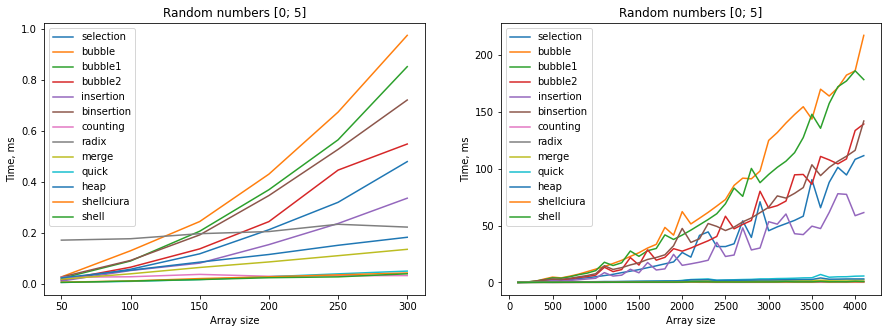

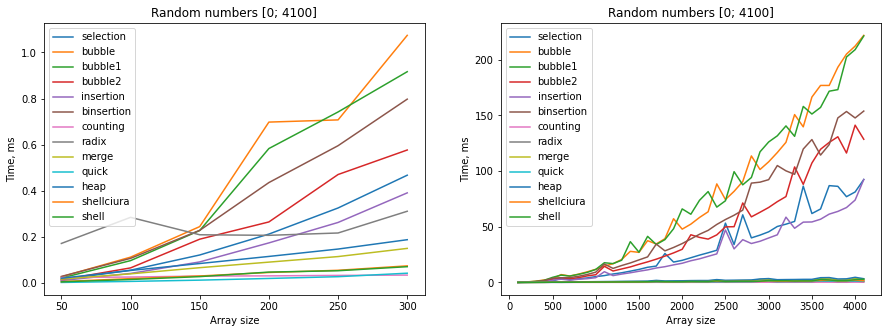

In [ ]:
plot_sortings_comparison(df_random_5, "Random numbers [0; 5]", "Time, ms")
plot_sortings_comparison(df_random_4000, "Random numbers [0; 4100]", "Time, ms")

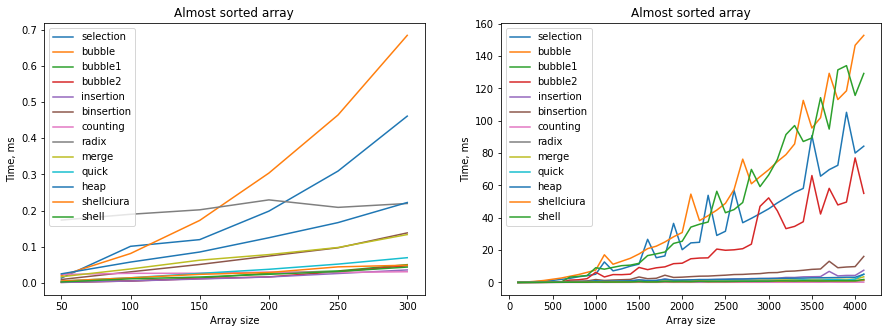

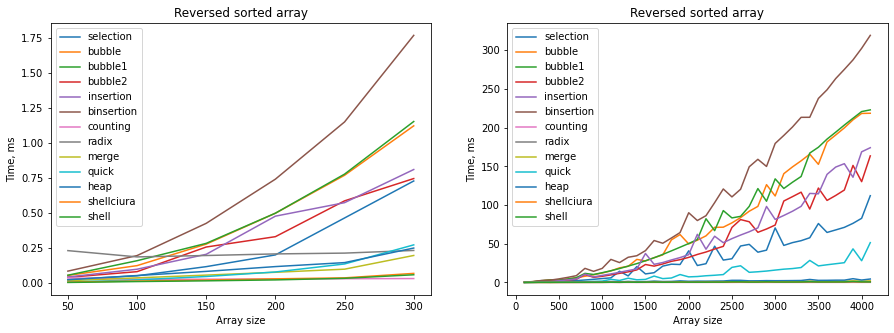

In [ ]:
plot_sortings_comparison(df_almost_sorted, "Almost sorted array", "Time, ms")
plot_sortings_comparison(df_reversed, "Reversed sorted array", "Time, ms")

### Сравнение эффективности работы с разными массивами в пределах одной сортировки

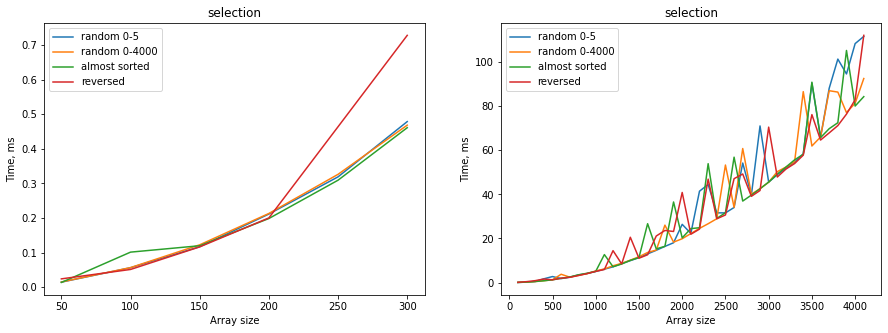

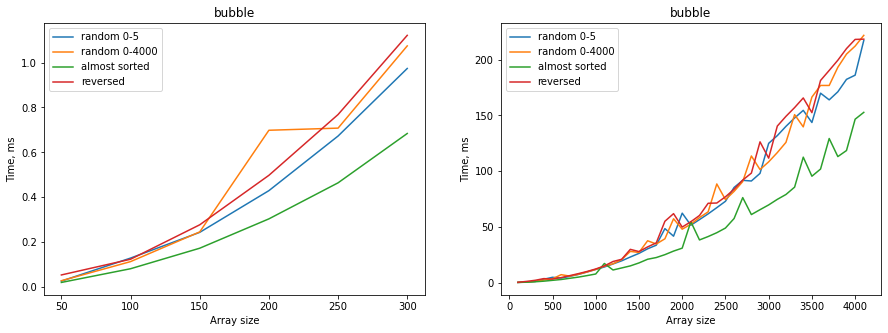

In [ ]:
for sorting in sorting_names[0:2]:
  plot_sortings(frames, sorting, "Time, ms")

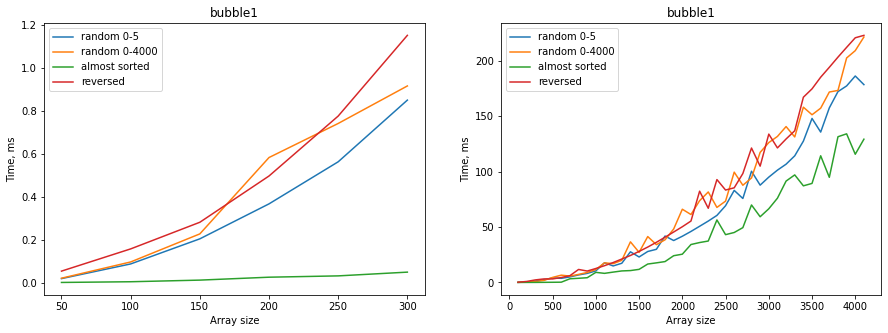

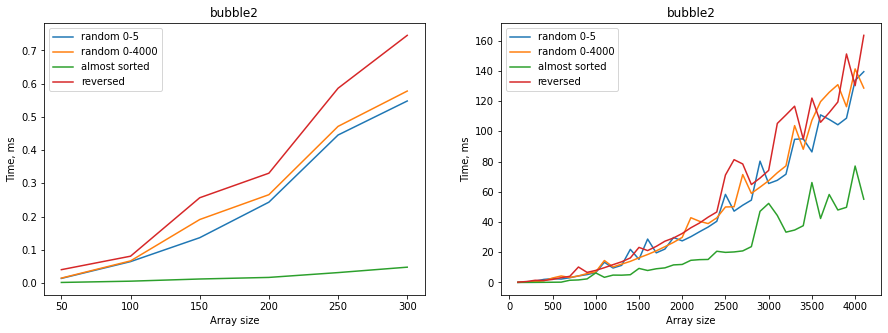

In [ ]:
for sorting in sorting_names[2:4]:
  plot_sortings(frames, sorting, "Time, ms")

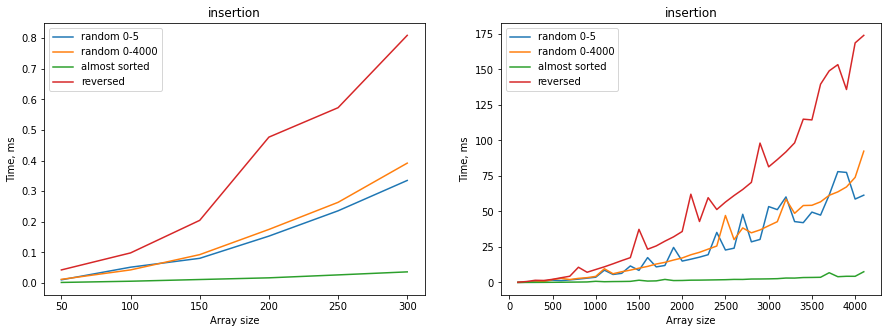

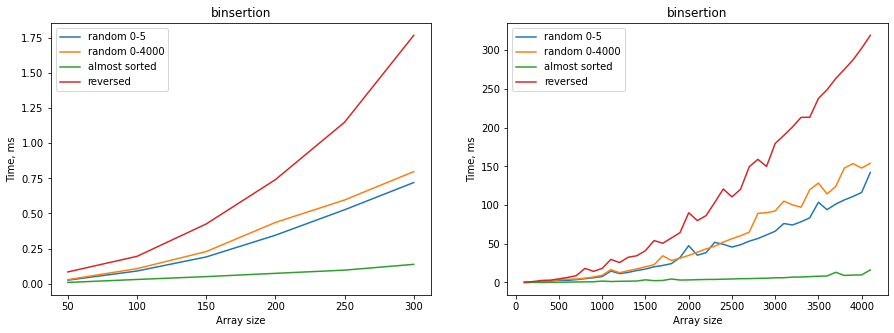

In [ ]:
for sorting in sorting_names[4:6]:
  plot_sortings(frames, sorting, "Time, ms")

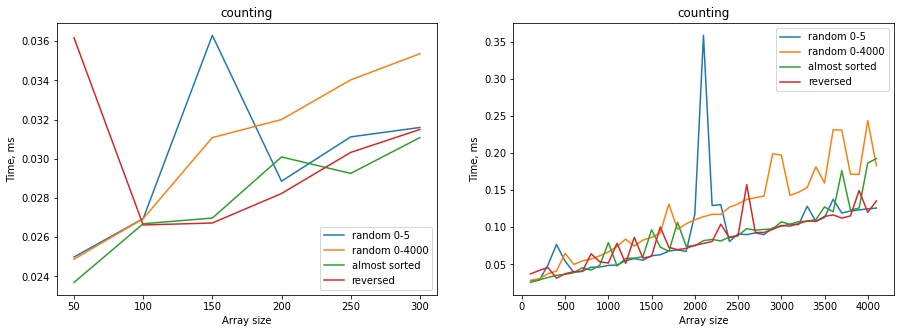

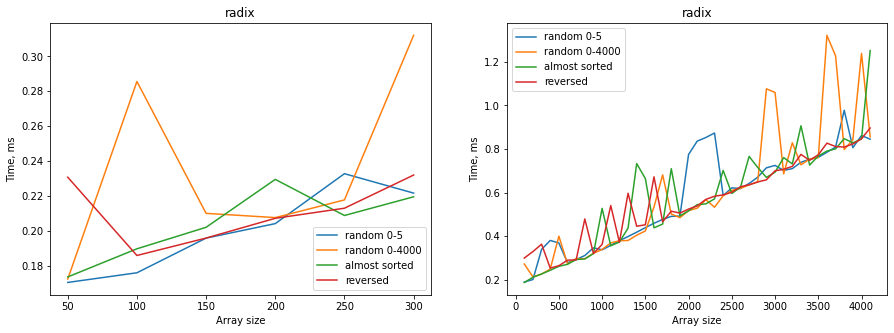

In [ ]:
for sorting in sorting_names[6:8]:
  plot_sortings(frames, sorting, "Time, ms")

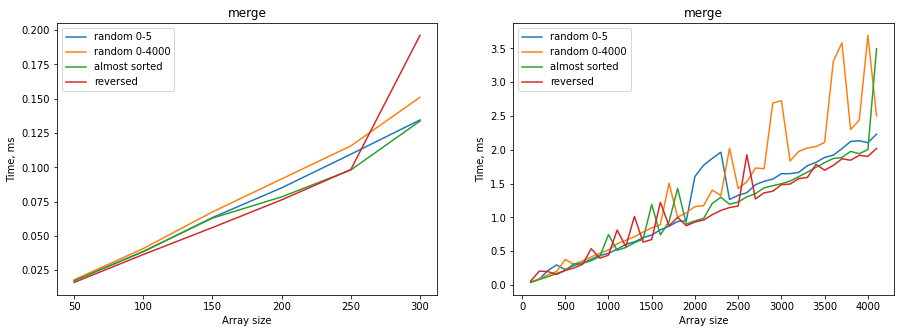

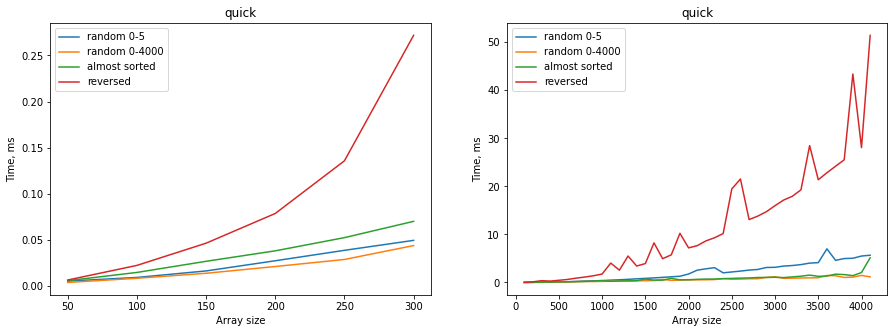

In [ ]:
for sorting in sorting_names[8:10]:
  plot_sortings(frames, sorting, "Time, ms")

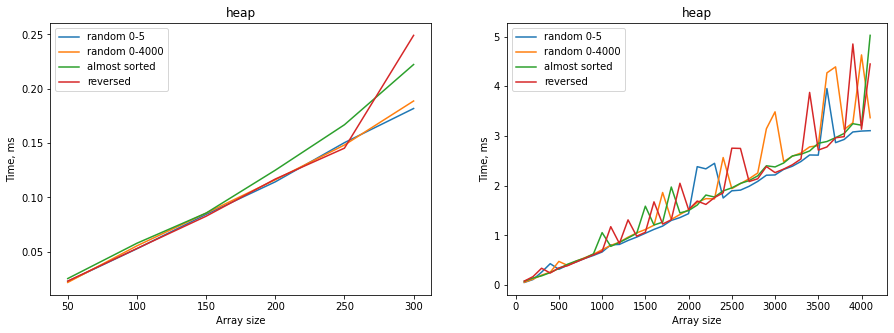

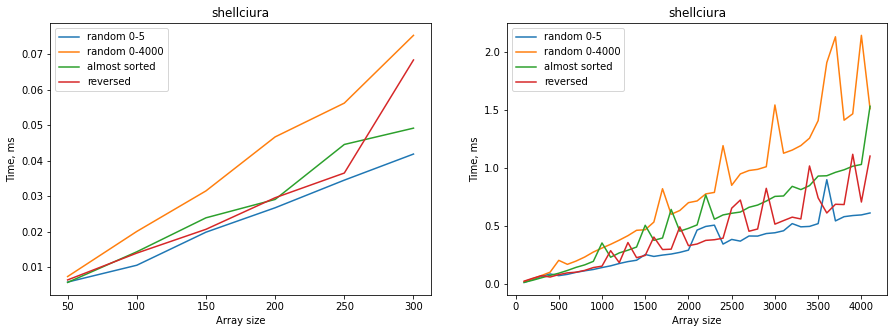

In [ ]:
for sorting in sorting_names[10:12]:
  plot_sortings(frames, sorting, "Time, ms")

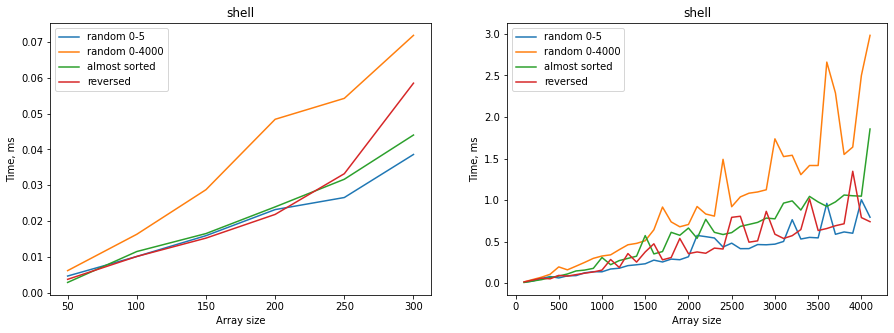

In [ ]:
for sorting in sorting_names[12:]:
  plot_sortings(frames, sorting, "Time, ms")